# Apply Deep Learning Project
### Peter Grantcharov (pdg2116)
### Po-Chieh Liu (pl2441)


#### INSATALL SLIDE READING PACKAGES

In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,001 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [3]:
# import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openslide import open_slide
from skimage.color import rgb2gray
from tqdm._tqdm_notebook import tnrange, tqdm
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf


TensorFlow 2.x selected.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def verify_validity(top_left, dims, image_dims):
    assert len(top_left) == 2, "Top left corner needs to have length 2"
    assert len(dims) == 2, 'Dims have to be length 2'
    
    msg = f"Top left corner {top_left} is outside image {image_dims}"
    assert top_left[0] < image_dims[0] and top_left[1] < image_dims[1], msg


In [0]:
def get_x_y(top_left, level):
    """
    Gets the top left corner for image of the level we're fetching.
    """
    scale = (2 ** level)
    return tuple(np.array(top_left) * scale)

def get_width_height(top_left, dims, image_dims):
    """
    Gets height and width; ensures that it does not go outside the
    image borders.
    """
    width = min(image_dims[0] - top_left[0], dims[0])
    height = min(image_dims[1] - top_left[1], dims[1])
    return width, height


In [0]:
def read_slide(slide, top_left, level, dims):
    """
    Give corner pixel values (top_left) for image of the level 
    we're fetching, instead of the highest resolution image.
    
    Dims are amount of (x, y) pixels to include.
    """
    image_dims = slide.level_dimensions[level]
    verify_validity(top_left, dims, image_dims)

    x, y = get_x_y(top_left, level)
    width, height = get_width_height(top_left, dims, image_dims)
    im = slide.read_region((x, y), level, (width, height)).convert('RGB')
    return np.asarray(im).copy()


# Heat map code

In [0]:
def plot_heatmap(slide):
    """
    Slide colors must be pre-edited 
    """
    fig, ax = plt.subplots()
    fig.set_dpi(200)

    # make grid
    ax.set_xticks(np.arange(0, slide.shape[1], 300))
    ax.set_yticks(np.arange(0, slide.shape[0], 300))
    ax.xaxis.grid(True, which='major', color='black', linewidth=0.2)
    ax.yaxis.grid(True, which='major', color='black', linewidth=0.2)
    ax.tick_params(labelbottom=False, labelleft=False, length=0)

    plt.imshow(slide)
    plt.show()


In [0]:
def taint_positives(slide, corners, predictions):
    tainted = slide.copy()
    for idx, (x, y) in enumerate(corners):
        if predictions[idx]:
            tainted[y:(y + 300), x:(x + 300), :][:, :, 0] = 0
    return tainted


In [0]:
def get_pred_class(truth, pred):
    first = 't' if truth == pred else 'f'
    second = 'p' if pred == 1 else 'n'
    return first + second


In [0]:
def visualize_conf_matrix(slide_shape, corners, y_true, y_pred):
    conf_matrix = np.zeros((slide_shape[1] // 300, slide_shape[0] // 300, 3))
    color_map = {'tn': ((0, 0), (1, 128), (2, 255)), 
                 'fp': ((0, 255), (1, 153), (2, 51)), 
                 'fn': ((0, 204), (1, 0), (2, 0)), 
                 'tp': ((0, 0), (1, 153), (2, 76))}

    for idx, (truth, pred) in enumerate(zip(y_true, y_pred)):
        pred_class = get_pred_class(truth, pred)
        x, y = corners[idx]

        for channel, value in color_map[pred_class]:
            conf_matrix[y // 300, x // 300, channel] = value

    return conf_matrix.astype(int)


# Test set performance


In [0]:
archive = pd.read_csv('drive/My Drive/ADL project/archive.csv', index_col=None)
test_results = pd.read_csv('drive/My Drive/ADL project/test_prediction.csv', index_col=None)
lr_results = pd.read_csv('drive/My Drive/ADL project/lr_results.csv', index_col=None)


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


### From just neural network

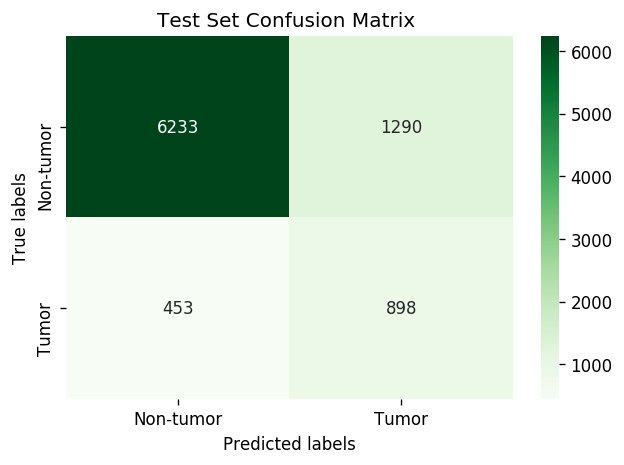

In [17]:
def plot_conf_matrix(cm, title_add_on=''):
    fig, ax = plt.subplots()
    fig.set_dpi(120)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Test Set Confusion Matrix {title_add_on}')
    ax.xaxis.set_ticklabels(['Non-tumor', 'Tumor'])
    ax.yaxis.set_ticklabels(['Non-tumor', 'Tumor'])
    plt.show()

cm = confusion_matrix(test_results.labels == 1, test_results.predictions >= 0.5)
plot_conf_matrix(cm)

In [18]:
print(f'Test set accuracy {((cm[0, 0] + cm[1, 1]) / cm.sum()):.2f}')
print(f'Test set recall {((cm[1, 1]) / (cm[1, 0] + cm[1, 1])):.2f}')
print(f'Test set precision {((cm[1, 1]) / (cm[0, 1] + cm[1, 1])):.2f}')


Test set accuracy 0.80
Test set recall 0.66
Test set precision 0.41


### From neural net + logistic regression from neighbor probabilities

In [0]:
all_test_images = list(test_results.slide_name.unique())
new_test_images = ['tumor_031', 'tumor_091', 'tumor_110']
new_train_images = [c for c in all_test_images if c not in new_test_images]


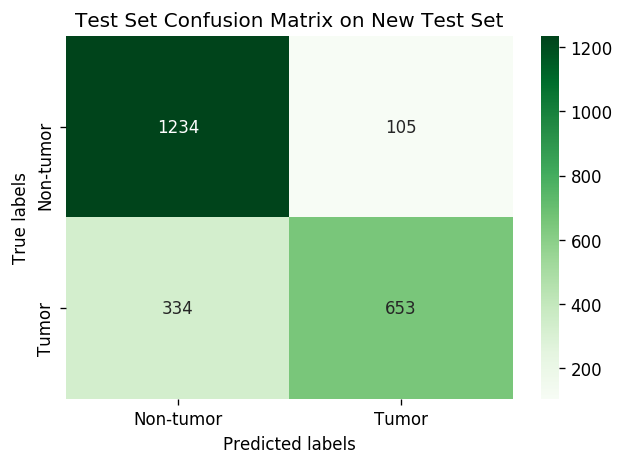

In [20]:
cm = confusion_matrix(lr_results.labels == 1, lr_results.predictions >= 0.5)
plot_conf_matrix(cm, 'on New Test Set')


In [0]:
print(f'Test set accuracy {((cm[0, 0] + cm[1, 1]) / cm.sum()):.2f}')
print(f'Test set recall {((cm[1, 1]) / (cm[1, 0] + cm[1, 1])):.2f}')
print(f'Test set precision {((cm[1, 1]) / (cm[0, 1] + cm[1, 1])):.2f}')


Test set accuracy 0.81
Test set recall 0.66
Test set precision 0.86


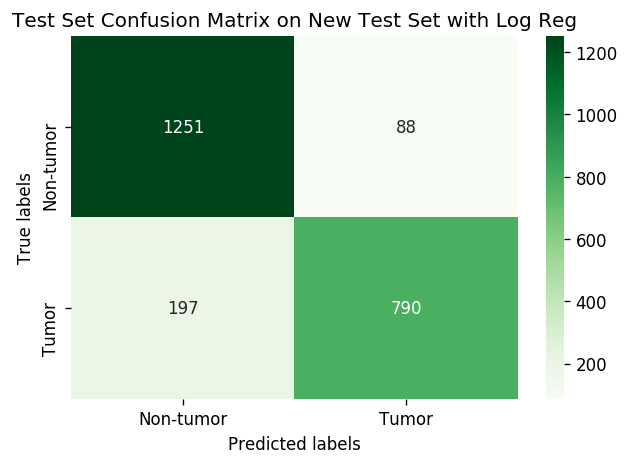

In [21]:
cm = confusion_matrix(lr_results.labels == 1, lr_results.lr_preds >= 0.5)
plot_conf_matrix(cm, 'on New Test Set with Log Reg')


In [0]:
print(f'Test set accuracy {((cm[0, 0] + cm[1, 1]) / cm.sum()):.2f}')
print(f'Test set recall {((cm[1, 1]) / (cm[1, 0] + cm[1, 1])):.2f}')
print(f'Test set precision {((cm[1, 1]) / (cm[0, 1] + cm[1, 1])):.2f}')


Test set accuracy 0.88
Test set recall 0.80
Test set precision 0.90


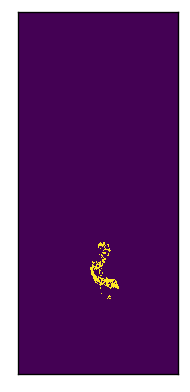

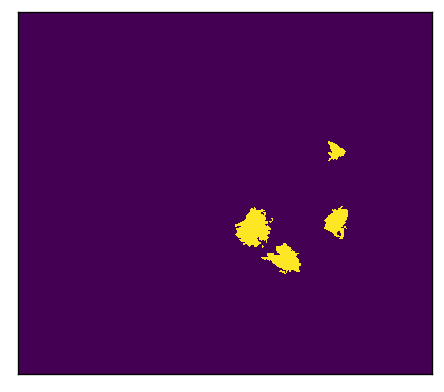

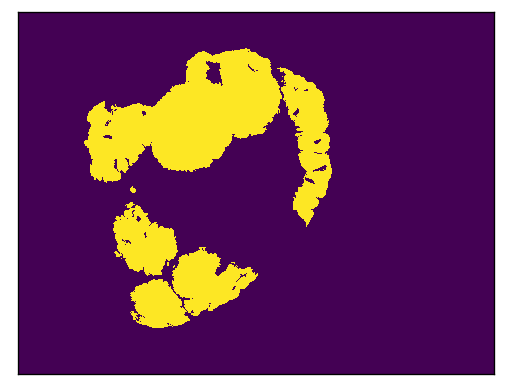

In [0]:
for name in new_test_images:
    fig, ax = plt.subplots()
    fig.set_dpi(120)
    mask = open_slide(f'drive/My Drive/ADL_images/{name}_mask.tif')
    plt.imshow(read_slide(mask, (0, 0), 6, mask.level_dimensions[6])[:, :, 0])
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.show()


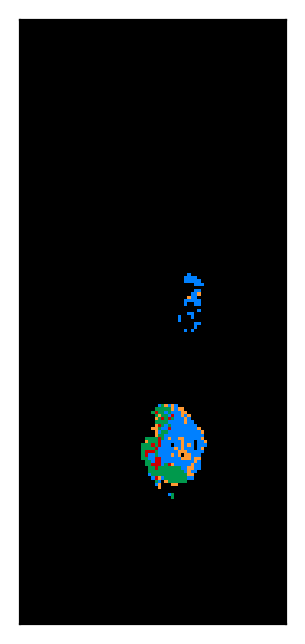

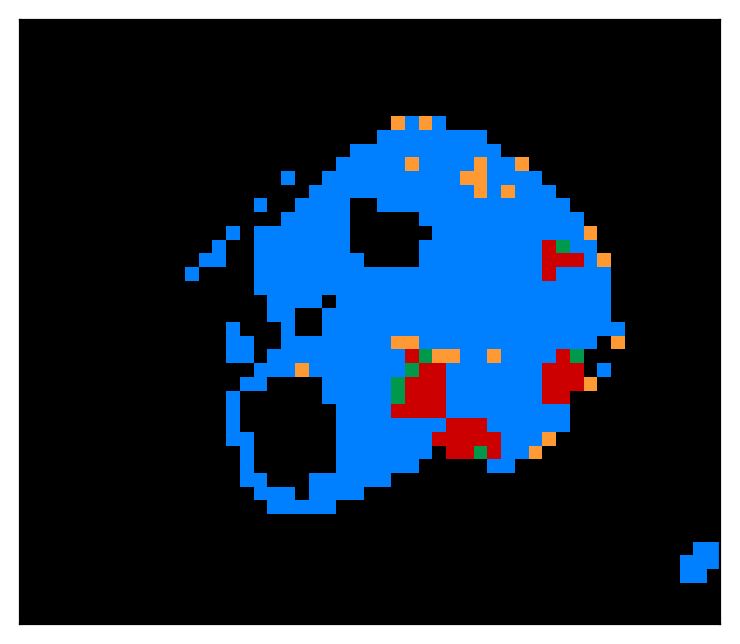

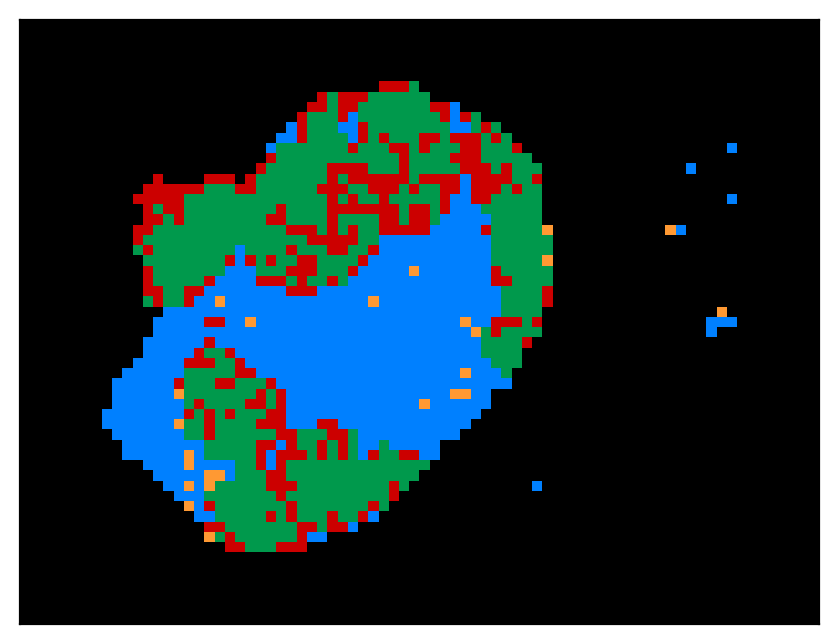

In [0]:
for name in new_test_images:
    slide = open_slide(f'drive/My Drive/ADL_images/{name}.tif')
    sub_archive = test_results.loc[test_results.slide_name == name]
    corners = tuple(zip(sub_archive.x, sub_archive.y))
    preds = sub_archive.predictions
    cm = visualize_conf_matrix(slide.level_dimensions[2], 
                               corners, 
                               sub_archive.labels == 1, 
                               preds > 0.5)
    plot_heatmap(cm)


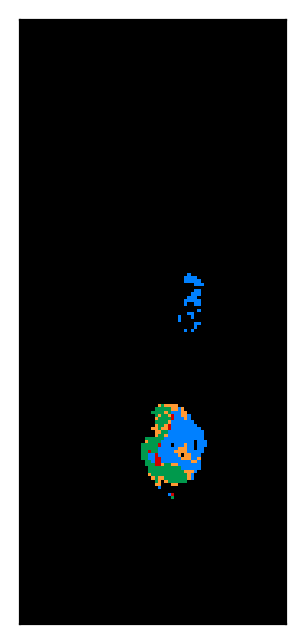

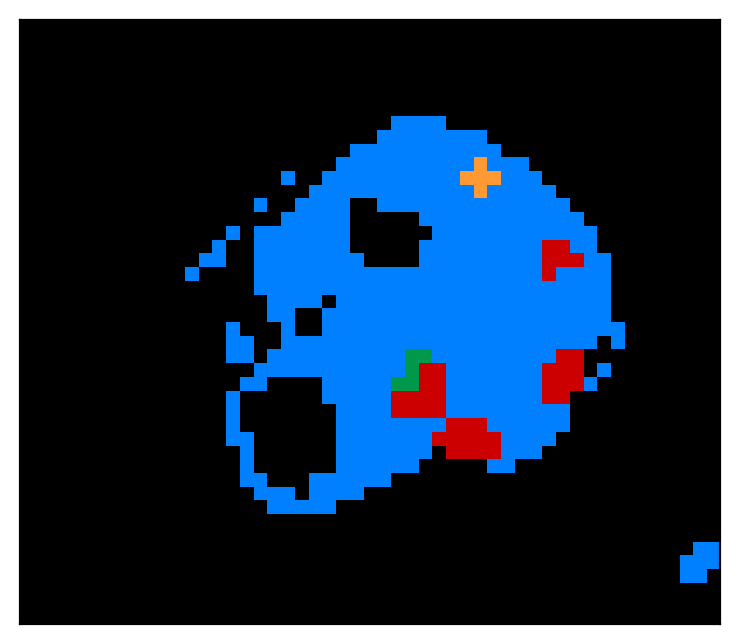

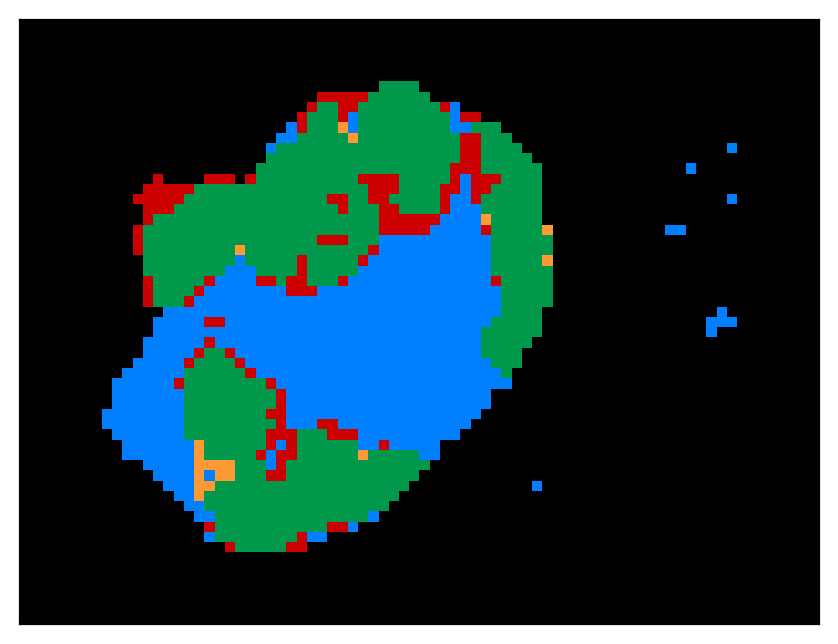

In [0]:
for name in new_test_images:
    slide = open_slide(f'drive/My Drive/ADL_images/{name}.tif')
    sub_archive = lr_results.loc[lr_results.slide_name == name]
    corners = tuple(zip(sub_archive.x, sub_archive.y))
    preds = sub_archive.lr_preds
    cm = visualize_conf_matrix(slide.level_dimensions[2], 
                               corners, 
                               sub_archive.labels == 1, 
                               preds > 0.5)
    plot_heatmap(cm)

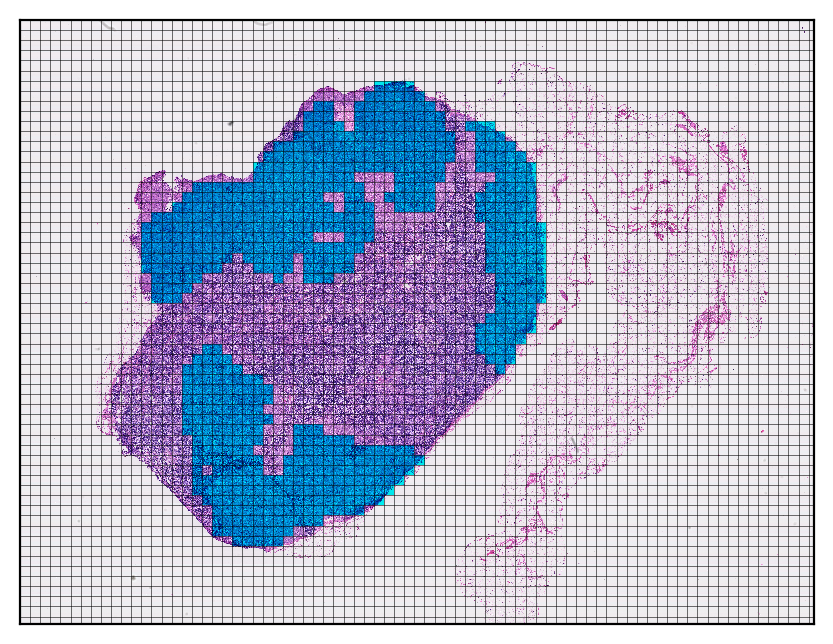

In [0]:
sample_slide = read_slide(slide, (0, 0), 2, slide.level_dimensions[2])
plot_heatmap(taint_positives(slide=sample_slide,
                             corners=corners, 
                             predictions=preds > 0.5))


# True positives 

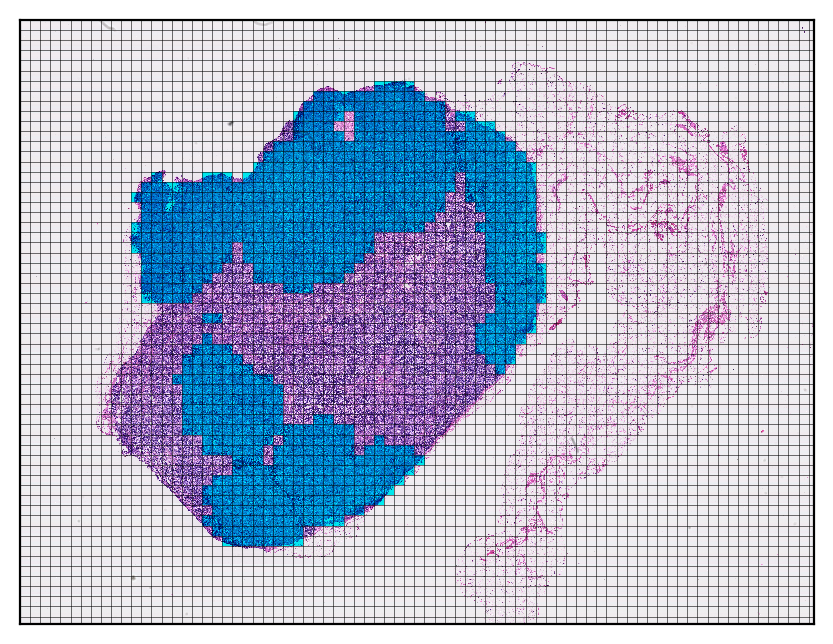

In [0]:
plot_heatmap(taint_positives(slide=sample_slide,
                             corners=corners, 
                             predictions=sub_archive.labels==1))
